In [ ]:
# Kaggle Challenge :
#  https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

 99% 3.64G/3.66G [00:30<00:00, 114MB/s]
100% 3.66G/3.66G [00:30<00:00, 127MB/s]


In [ ]:
!unzip /content/rsna-pneumonia-detection-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_trai

In [ ]:
!pip install pydicom
!pip install torchmetrics
!pip install pytorch-lightning
  
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


In [ ]:
labels = pd.read_csv("/content/stage_2_train_labels.csv")
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
labels.drop_duplicates("patientId",inplace=True)

In [ ]:
root_path = Path("/content/stage_2_train_images")
save_path = Path("Processed")

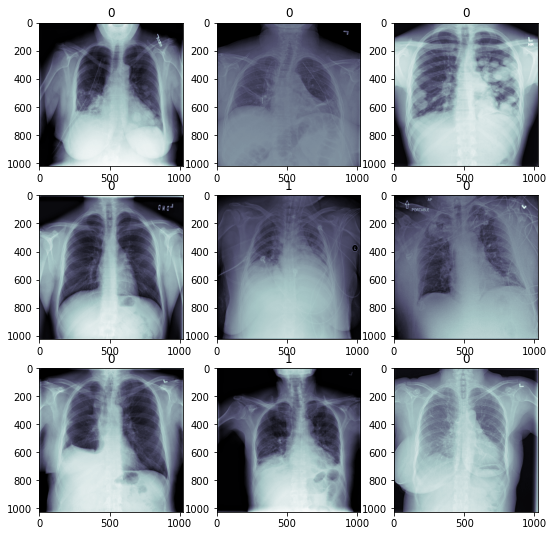

In [ ]:
fig , ax = plt.subplots(3,3,figsize=(9,9))
c = 0
for i in range(3):
  for j in range(3):
    patient_id = labels.patientId.iloc[c]
    dcm_path = root_path/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.read_file(dcm_path).pixel_array
    label = labels["Target"].iloc[c]

    ax[i][j].imshow(dcm,cmap="bone")
    ax[i][j].set_title(label)
    c+=1

In [ ]:
sums, sum_squared = 0 ,0
for c,patient_id in enumerate(tqdm(labels.patientId)):
    patient_id = labels.patientId.iloc[c]
    dcm_path = root_path/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.read_file(dcm_path).pixel_array/255

    dcm_array = cv2.resize(dcm,(222,224)).astype(np.float16)

    label = labels.Target.iloc[c]

    train_or_val = "train" if c <24000 else "val"

    current_save_path = save_path/train_or_val/str(label)
    current_save_path.mkdir(parents=True,exist_ok=True)
    np.save(current_save_path/patient_id,dcm_array)

    normalizer = 224*224
    if train_or_val == "train":
      sums += np.sum(dcm_array)/normalizer
      sum_squared += (dcm_array **2 ).sum()/normalizer 



  0%|          | 0/26684 [00:00<?, ?it/s]

In [ ]:
mean = sums / 24000
std = np.sqrt((sum_squared/24000) -mean**2)

In [ ]:
print("mean ",mean)
print("std deviation ", std)

mean  0.48601678425276007
std deviation  0.2511174564987606


In [ ]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [ ]:
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,std),
                                      transforms.RandomAffine(degrees=(-5,5),translate=(0,0.5),scale=(0.9,1.1)),
                                      transforms.RandomResizedCrop((224,224),scale=(.35,1))]
                                      
)

val_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,std)]

                                      
)

In [ ]:
train_dataset = torchvision.datasets.DatasetFolder("/content/Processed/train/",loader = load_file,extensions="npy",
                                                    transform=train_transforms)
val_dataset = torchvision.datasets.DatasetFolder("/content/Processed/val/",loader = load_file,extensions="npy",
                                                    transform=val_transforms)


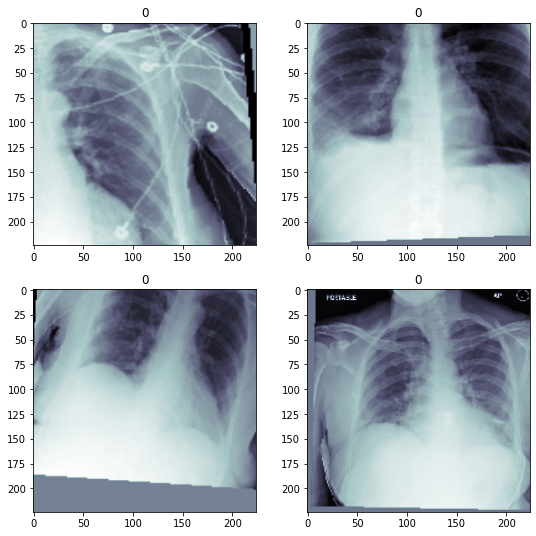

In [ ]:
fig , ax = plt.subplots(2,2,figsize=(9,9))

for i in range(2):
  for j in range(2):
    random_index = np.random.randint(0,24000)
    x_ray ,label = train_dataset[random_index]
    ax[i][j].imshow(x_ray[0],cmap="bone")
    ax[i][j].set_title(label)

In [ ]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
batch_size =64
num_workers = 64

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class PneumoniaModel(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.model = torchvision.models.resnet18()
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
    self.optimizer = torch.optim.Adam(self.model.parameters(),lr=1e-4)
    self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()

  def forward(self,data):
    pred = self.model(data)
    return pred
  
  def training_step(self,batch,batch_idx):
    x_ray,label = batch
    label = label.float()
    pred = self(x_ray)[:,0]
    loss = self.loss_fn(pred,label)

    self.log("Train Loss",loss)
    self.log("Step Train acc",self.train_acc(torch.sigmoid(pred),label.int()))
    return loss

  def training_epoch_end(self,outs):
    self.log("Train acc",self.train_acc.compute())

  # -------coping--------
  def val_step(self,batch,batch_idx):
    x_ray,label = batch
    label = label.float()
    pred = self(x_ray)[:,0]
    loss = self.loss_fn(pred,label)

    self.log("Val Loss",loss)
    self.log("Step Val acc",self.val_acc(torch.sigmoid(pred),label.int()))


  def val_epoch_end(self,outs):
    self.log("Val acc",self.val_acc.compute())

  def configure_optimizers(self):
    return [self.optimizer]


In [ ]:
model = PneumoniaModel()


In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="VAL ACC",
    save_top_k=10,
    mode="max"
)

In [ ]:
from gc import callbacks
gpus = 1

trainer = pl.Trainer(gpus=-1,
                     logger=TensorBoardLogger(save_dir="/content/logs"),
                     log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model,train_loader,val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/logs/default

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:644: UserWarning: ModelCheckpoint(monitor='VAL ACC') not found in the returned metrics: ['Train Loss', 'Step Train acc', 'Train acc']. HINT: Did you call self.log('VAL ACC', value) in the LightningModule?
  warning_cache.warn(m)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than 

In [ ]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

model = PneumoniaModel.load_from_checkpoint("weights/weights_3.ckpt")
model.eval()
model.to(device)


NameError: ignored

In [ ]:
preds = []
labels = []

with torch.no_grad():
  for data,label in tqdm(val_dataset):
    data = data.to(device).float().unsqueeze(0)
    pred = torch.sigmoid(model(data)[0].cpu())
    preds.append(pred)
    labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).init()


In [ ]:
acc = torchmetrics.Accuracy()(preds,labels)
precision = torchmetrics.Precision()(preds,labels)
recall = torchmetrics.Recall()(preds,labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds,labels)

In [ ]:
print(f"Val Accuracy {acc}")
print(f"Val Precision {precision}")
